# Modelling with SVM regressor<br>

In [1]:
## Import packages
import pandas as pd
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import missingno as msno
import sklearn.model_selection as ms
import sklearn.metrics as sklm
from sklearn import feature_selection as fs
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
import scipy.stats as ss
import seaborn as sns
import math
import warnings

sns.set_style('darkgrid')
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train = pd.read_csv('Unskewed_Train.csv', index_col="row_id")
labels = pd.read_csv('Predicting_Chronic_Hunger_Training_labels.csv', index_col="row_id")
test = pd.read_csv('Unskewed_Test.csv', index_col="row_id")

In [3]:
print ('The train data has {0} rows and {1} columns'.format(train.shape[0],train.shape[1]))
print ('-------------------------------------------')
print ('The test data has {0} rows and {1} columns'.format(test.shape[0],train.shape[1]))

The train data has 1337 rows and 35 columns
-------------------------------------------
The test data has 616 rows and 35 columns


In [4]:
train['undernourishment'] = labels.iloc[train.index]

Functions to make copy of the imports, create training/test sets, print the metrics, save the results. 

In [5]:
def copy_values(train_features, train_labels, test_features):
    ## Create features and labels for training/testing models:
    features = train_features.copy().drop('undernourishment', axis=1)
    labels = train_labels.copy()
    labels = labels[labels.index.isin(features.index)]

    ## Create a copy of the features datasets for which we want to predict values
    predict = test_features.copy()
    
    return features, labels, predict

def create_sets(Features, Labels, features_to_use):
    """Creates the X and y sets for training and testing.
    """    
    ## Groupby country code to separate the countries in training and test set
    nr.seed(1234)
    grouped = Features.groupby('country_code')
    indx = range(grouped.ngroups)
    indx = ms.train_test_split(indx, test_size = 0.3, random_state=42)
    
    ## Create index of country_code
    train_index = Features[Features['country_code'].isin([(list(np.array(list(grouped.groups.keys())))[ix]) for ix in indx[0]])].index
    test_index = Features[Features['country_code'].isin([(list(np.array(list(grouped.groups.keys()))))[ix] for ix in indx[1]])].index


    ## Create the train and test sets of features
    X_train = np.array(Features[Features.index.isin(train_index)][features_to_use])
    X_test = np.array(Features[Features.index.isin(test_index)][features_to_use])
    ## Create the train and test sets of labels
    y_train = np.ravel(np.array(Labels[Labels.index.isin(train_index)]))
    y_test = np.ravel(np.array(Labels[Labels.index.isin(test_index)]))
    
    return X_train, y_train, X_test, y_test

def print_metrics(y_true, y_predicted, n_parameters):
    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_true, y_predicted)
    r2_adj = r2 - (n_parameters - 1)/(y_true.shape[0] - n_parameters) * (1 - r2)
    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_true, y_predicted)))
    print('R^2                    = ' + str(r2))
    print('Adjusted R^2           = ' + str(r2_adj))

    
    
## PRINT THE CROSS VALIDATION RESULTS:


def print_format(f,x,y,z):
    print('Fold %2d    %4.3f        %4.3f      %4.3f' % (f, x, y, z))

def print_cv(scores):
    fold = [x + 1 for x in range(len(scores['test_neg_mean_squared_error']))]
    
    print('           RMSE         R2         Explained Var')
    
    [print_format(f,x,y,z) for f,x,y,z in zip(fold, np.sqrt(abs(scores['test_neg_mean_squared_error'])), 
                                          scores['test_r2'],
                                          scores['test_explained_variance'])]
    print('-' * 40)
    print('Mean       %4.3f        %4.3f      %4.3f' % 
          (np.mean(np.sqrt(abs((scores['test_neg_mean_squared_error'])))), np.mean(scores['test_r2']), np.mean(scores['test_explained_variance'])))  
    print('Std        %4.3f        %4.3f      %4.3f' % 
          (np.std(np.sqrt(abs((scores['test_neg_mean_squared_error'])))), np.std(scores['test_r2']), np.std(scores['test_explained_variance'])))

In [6]:
to_use = list(train.columns[1:-1])

## SVM Regressor:

Doesn't assume normality but try to minimize a symetric loss functions. SVMs assume that the data it works with is in a standard range, usually either 0 to 1, or -1 to 1 (roughly). So the normalization of feature vectors prior to feeding them to the SVM is very important.

In [7]:
# Make a copy of the imports
features, labels, predict = copy_values(train, labels, test)
# Create the training and test sets
X_train, y_train, X_test, y_test = create_sets(features, labels, to_use)

# Scale the features on the training set
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
SVMreg = SVR(kernel='linear')
SVMreg.fit(X_train, y_train)

scores = SVMreg.predict(X_test)
print_metrics(y_test, scores, 3)

Mean Square Error      = 58.52800309948059
Root Mean Square Error = 7.650359671249489
Mean Absolute Error    = 5.95118701335013
Median Absolute Error  = 4.791613957078607
R^2                    = 0.5866217776348961
Adjusted R^2           = 0.5846102047766717


Our results seem encouraging. We will try to reduce the number of feature. However, Sklearn implementation doesn't allow feature selection with kernels other than linear.

In [9]:
def hist_resids(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.distplot(resids)
    plt.title('Histogram of residuals')
    plt.xlabel('Residual value')
    plt.ylabel('count')
    plt.show()
    
def resid_qq(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test, y_score)
    ## now make the residual plots
    ss.probplot(resids.flatten(), plot = plt)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
    plt.show()

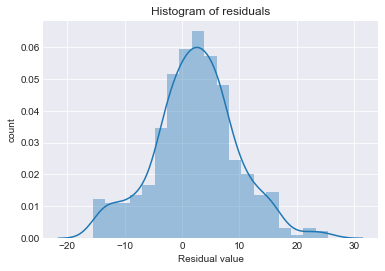

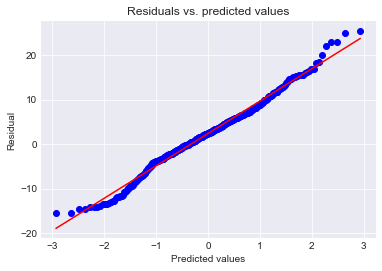

In [10]:
hist_resids(y_test, scores)  
resid_qq(y_test, scores)

## Recursive Feature Elimination

In [11]:
X_train, y_train, X_test, y_test = create_sets(train, train['undernourishment'], to_use)
# Scale the features on the training set
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
estimator = SVR(kernel='linear') ## Only available for linear kernel. The results with the features reduced are however worse. 
selector = RFE(estimator)
selector = selector.fit(X_train, y_train)
selector.support_
selector.ranking_

array([13,  1,  1, 11, 16,  1, 18,  1,  4,  1,  1, 10,  9,  3, 15,  2,  5,
       17,  1,  1,  8,  1,  1,  1,  1, 12, 14,  7,  1,  1,  1,  1,  6,  1])

In [13]:
## Features selected with RFE
indexes = [i for i, x in enumerate(selector.ranking_) if x == 1 ]
RFE_features = list(np.array(to_use)[indexes])
RFE_features

['agricultural_land_area',
 'percentage_of_arable_land_equipped_for_irrigation',
 'fertility_rate',
 'rural_population',
 'avg_value_of_food_production',
 'cereal_import_dependency_ratio',
 'avg_supply_of_protein_of_animal_origin',
 'caloric_energy_from_cereals_roots_tubers',
 'anemia_prevalence',
 'obesity_prevalence',
 'open_defecation',
 'co2_emissions',
 'urban_population_share',
 'co2em_share',
 'adult_illiteracy_rate',
 'no_electricity',
 'no_access_water_sources']

In [14]:
# Make a copy of the imports
features, labels, predict = copy_values(train, labels, test)
# Create the training and test sets
X_train, y_train, X_test, y_test = create_sets(features, labels, RFE_features)

# Scale the features on the training set
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

SVMreg.fit(X_train, y_train)

scores = SVMreg.predict(X_test)
print_metrics(y_test, scores, 3)

Mean Square Error      = 55.88587370200682
Root Mean Square Error = 7.475685500474643
Mean Absolute Error    = 5.646997045084182
Median Absolute Error  = 4.221812894218411
R^2                    = 0.6052829089864966
Adjusted R^2           = 0.6033621445533409


In [15]:
scoring = ['neg_mean_squared_error', 'r2', 'explained_variance']
scores = ms.cross_validate(estimator = SVMreg, X = X_train, y = y_train, scoring=scoring, cv=5, return_train_score=False)
print_cv(scores)

           RMSE         R2         Explained Var
Fold  1    7.509        0.653      0.672
Fold  2    6.761        0.698      0.710
Fold  3    6.527        0.642      0.649
Fold  4    6.082        0.672      0.673
Fold  5    6.295        0.698      0.707
----------------------------------------
Mean       6.635        0.673      0.682
Std        0.493        0.023      0.023


With Recursive Features Elimination, we reduce the datasets from 34 features to 17 improving the RMSE.

## Tuning Hyper Parameters (C, gamma and the kernel)

In [ ]:
X_train, y_train, X_test, y_test = create_sets(train, train['undernourishment'], to_use)

# Scale the features on the training set
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Instantiate model
estimator = SVR()
# Parameter grid
parameters = {'C':[0.1, 1, 10, 100, 1000], 
              'epsilon': [0.1, 0.01, 0.001, 0.0001, 0.00001]}

# Gridsearch with 5 folds cross-validation:
SVR_gridsearch = GridSearchCV(estimator, parameters, cv=5, scoring='neg_mean_squared_error')
SVR_gridsearch.fit(X_train, y_train)

In [ ]:
SVR_gridsearch.best_params_

In [ ]:
# Make a copy of the imports
features, labels, predict = copy_values(train, labels, test)

# Create the training and test sets
X_train, y_train, X_test, y_test = create_sets(features, labels, to_use)

# Scale the features on the training set
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

SVRbest = SVR(kernel='linear', C=1000, epsilon=0.1, gamma='auto', tol = 0.001)
SVRbest.fit(X_train, y_train)

scores = SVRbest.predict(X_test)
print_metrics(y_test, scores, 3)

The tuned HyperParameters set seem to yield worse results than the default following results.

In [ ]:
SVMreg.get_params()

In [ ]:
hist_resids(y_test, scores)  
resid_qq(y_test, scores)

In [ ]:
scoring = ['neg_mean_squared_error', 'r2', 'explained_variance']
scores = ms.cross_validate(estimator = SVMreg, X = X_train, y = y_train, scoring=scoring, cv=5, return_train_score=False)
print_cv(scores)